## In this notebook we will modeling play by play yac data


In [1]:
##Import required packages
#Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import os
#For model creation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf

#Dimensionality reduction
from sklearn.decomposition import PCA

#For scaling data
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

#Plotting animation
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
#Lets first get all of our data into pandas dataframes
games = pd.read_csv('data/games.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tackles = pd.read_csv('data/tackles.csv')
# Assuming your tracking data files are named tracking_week_1.csv, tracking_week_2.csv, ..., tracking_week_9.csv
data_dir = Path("data/")  # Update with the correct path
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))

# Create an empty list to store individual week dataframes
week_dfs = []

# Iterate through each tracking data file and load it into a dataframe
for week_number, tracking_file in enumerate(tracking_dfs, start=1):
    week_df = pd.read_csv(tracking_file)
    
    # Add a 'week' column with the corresponding week number
    week_df['week'] = week_number
    
    # Append the dataframe to the list
    week_dfs.append(week_df)

# Combine all week dataframes into a single dataframe
tracking = pd.concat(week_dfs, ignore_index=True)


In [4]:
#Filter out any non-pass plays
yac_df = plays[['gameId','playId','ballCarrierId','ballCarrierDisplayName','yardsToGo','possessionTeam','defensiveTeam','yardlineSide','yardlineNumber']]
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41
1,2022091103,3126,52457,Chase Claypool,10,PIT,CIN,PIT,34
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35
...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34


In [5]:
# Get plays with 'first_contact' event
plays_with_first_contact = tracking[tracking['event'] == 'first_contact'][['gameId', 'playId']].drop_duplicates()

# Get plays with the specified events
relevant_events = ['pass_outcome_caught', 'run', 'handoff']
plays_with_other_events = tracking[tracking['event'].isin(relevant_events)][['gameId', 'playId']].drop_duplicates()

# Filter yac_df for plays that satisfy both conditions
filtered_plays = plays_with_first_contact.merge(plays_with_other_events, on=['gameId', 'playId'], how='inner')
yac_df = yac_df[yac_df.set_index(['gameId', 'playId']).index.isin(filtered_plays.set_index(['gameId', 'playId']).index)]


## Calculate yards gained after the 'first_contact' frame

In [6]:
def yards_after_contact(row, tracking):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking[(tracking.gameId == gameId) & (tracking.playId == playId) & (tracking.nflId == ballCarrierId)]

    # Check if there are matching rows
    if not selected_tracking.empty:
        first_contact_row = selected_tracking.loc[selected_tracking.event == 'first_contact', 'x']
        tackle_row = selected_tracking.loc[selected_tracking.event == 'tackle', 'x']

        # Check if rows with 'first_contact' and 'tackle' events exist
        if not first_contact_row.empty and not tackle_row.empty:
            x_first_contact = first_contact_row.values[0]
            x_tackle = tackle_row.values[0]

            play_direction = selected_tracking['playDirection'].values[0]

            if play_direction == 'right':
                yards_gained = x_tackle - x_first_contact
            else:
                yards_gained = x_first_contact - x_tackle

            # Forward progress rule
            yards_gained = max(0, yards_gained)
        else:
            # If events are not found, set yards_gained to 0
            yards_gained = 0
    else:
        # If no matching rows are found, set yards_gained to 0
        yards_gained = 0

    return yards_gained


In [7]:
yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35,2.97
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12
...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39,2.26
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34,0.00


## Which defender made first contact?
I will determine this by calculating the euclidean distance between all defenders and the ballcarrier at the frame of first contact. 

In [8]:
tracking_fc = pd.merge(tracking, plays[['gameId','playId', 'ballCarrierId', 'defensiveTeam']], on = ['gameId','playId'], how='left')


# Drop rows with NaN values in the 'nflId' column
tracking_fc.dropna(subset=['nflId'], inplace=True)

tracking_fc['nflId'] = pd.to_numeric(tracking_fc['nflId'], errors='coerce').astype(int)

tracking_fc = tracking_fc[(tracking_fc.nflId == tracking_fc.ballCarrierId) | (tracking_fc.club == tracking_fc.defensiveTeam)]
tracking_fc = tracking_fc[
    tracking_fc.set_index(['gameId', 'playId']).index.isin(yac_df.set_index(['gameId', 'playId']).index)
]

tracking_fc = pd.merge(tracking_fc, yac_df[['gameId','playId','ballCarrierDisplayName','yardsToGo','yards_after_contact']], on = ['gameId','playId'], how='left')

In [9]:
# Merge DataFrames based on gameId, playId, and nflId
tracking_fc = pd.merge(tracking_fc, tackles[['gameId', 'playId', 'nflId']], 
                     on=['gameId', 'playId', 'nflId'], how='left', indicator=True)

# Add a new column 'involved_in_tackle' with 1 if there is a match and 0 otherwise
tracking_fc['involved_in_tackle'] = (tracking_fc['_merge'] == 'both').astype(int)

# Drop the indicator column and any other columns introduced by the merge
tracking_fc.drop(['_merge'], axis=1, inplace=True)


In [10]:
# Filter the DataFrame to include only frames with 'first_contact' event
caught_frames = tracking_fc[tracking_fc['event'] == 'first_contact']

# Add a new column 'defender_first_contact' to tracking_fc
tracking_fc['defender_first_contact'] = np.nan

# Iterate through unique pairs of gameId and playId
for (game_id, play_id) in caught_frames[['gameId', 'playId']].drop_duplicates().itertuples(index=False):
    # Get the data for the current gameId and playId
    play_data = caught_frames[(caught_frames['gameId'] == game_id) & (caught_frames['playId'] == play_id)]
    
    # Get the coordinates of the ballcarrier
    ballcarrier_coords = play_data[play_data['nflId'] == play_data['ballCarrierId']][['x', 'y']].values[0]
    
    # Calculate Euclidean distance for each defender
    play_data['distance_to_ballcarrier'] = play_data.apply(
        lambda row: np.linalg.norm([row['x'] - ballcarrier_coords[0], row['y'] - ballcarrier_coords[1]]),
        axis=1
    )
    
    # Exclude the ballcarrier from the candidates for first contact
    play_data = play_data[play_data['nflId'] != play_data['ballCarrierId']]
    
    # Find the defender with the minimum distance (first contact)
    defender_first_contact = play_data.loc[play_data['distance_to_ballcarrier'].idxmin()]['nflId']
    
    # Fill the 'defender_first_contact' value for all rows with the same 'gameId' and 'playId'
    tracking_fc.loc[(tracking_fc['gameId'] == game_id) & (tracking_fc['playId'] == play_id), 'defender_first_contact'] = defender_first_contact

# Now, tracking_fc DataFrame has a new column 'defender_first_contact' with the defender's nflId for each first contact event.


In [11]:
tracking_fc['defender_first_contact'] = tracking_fc['defender_first_contact'].astype(int)

In [12]:

yac_df = pd.merge(yac_df, tracking_fc[['gameId', 'playId', 'defender_first_contact']].drop_duplicates(),
                  on=['gameId', 'playId'], how='left')

yac_df.rename(columns={'defender_first_contact': 'nflId'}, inplace=True)

print(yac_df.shape[0])

#only include plays where the first defender is also listed in the tackles dataframe
yac_df = yac_df[
    yac_df.set_index(['gameId', 'playId', 'nflId']).index.isin(tackles.set_index(['gameId', 'playId', 'nflId']).index)
]

yac_df.rename(columns={'nflId': 'defender_first_contact'}, inplace=True)

print(yac_df.shape[0])

10522
8705


## Feature Engineering
Lets come up with some variables that are likely to impact the success of a tackle. We will calculate:
1. Avg speed of both players between the pass catch and the collision
2. Distance the players are from one another at the time the pass was caught
3. Number of defenders near the ball at the time of first contact
4. Difference in angle between the defender and offense (from the offense pov)
5. Height and Weight of both the ballcarrier and the defender

## 1. Avg speed of both players between the pass catch and the collision

This will be calculated by the `get_avg_speed` function.

### Function Description:
The function `get_avg_speed` takes three arguments:
- `row`: Represents a row of our `yac_df`.
- `tracking_df`: Represents the dataframe from which we retrieve the tracking data.
- `defender`: Boolean indicating whether we are calculating the first defender's speed or ballcarrier's speed.

The function calculates the average speed of the players between the pass catch and the collision in the corresponding frame of `tracking_fc`. Speed will be calculated as the mean of the `s` values in `tracking_df` in the frames between when the ball carrier receives the ball and the `first_contact` frame.


In [13]:
def get_avg_speed(row, tracking_df, defender):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    last_frame = selected_tracking[selected_tracking.event == 'first_contact']['frameId'].values[0]
    numframes = last_frame - event_frame + 1

    speed_defender = 0
    speed_ballcarrier = 0
    
    for frame in range(event_frame, last_frame + 1):  # Use range to iterate over frames
        speed_defender += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == defenderId)]['s'].values[0] / numframes
        speed_ballcarrier += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['s'].values[0] / numframes


    if defender:
        return speed_defender
    else:
        return speed_ballcarrier


In [14]:
#Get the average speed of both the ballcarrier and the defender
yac_df.loc[:, 'avg_speed_defender'] = yac_df.apply(get_avg_speed, args=(tracking_fc, True), axis=1)
yac_df.loc[:, 'avg_speed_ballcarrier'] = yac_df.apply(get_avg_speed, args=(tracking_fc, False), axis=1)


After we apply our function using `.apply()`, our new `avg_speed_defender` and `avg_speed_ballcarrier` columns should look like this:

In [15]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','avg_speed_ballcarrier','avg_speed_defender','yards_after_contact']].head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,avg_speed_ballcarrier,avg_speed_defender,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,2.730000,5.120000,0.30
1,2022091111,1148,42547,Darren Waller,6.678000,5.296000,1.52
2,2022100212,2007,46461,Mike Boone,5.450000,3.015625,4.74
3,2022091900,1372,47857,Devin Singletary,4.212500,3.854375,2.97
4,2022103001,2165,54616,Tyler Allgeier,6.255714,5.929048,1.12


Let's also look at a scatterplot to see if we can determine any relationship between this `avg_speed_defender` and `yards_after_contact`

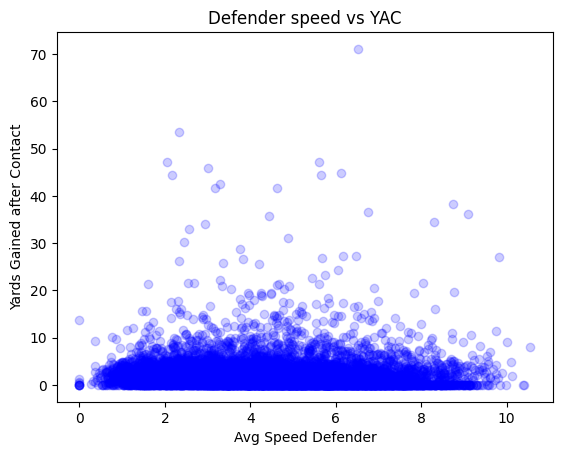

In [16]:
# Create a scatter plot
plt.scatter(yac_df['avg_speed_defender'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Avg Speed Defender')
plt.ylabel('Yards Gained after Contact')
plt.title('Defender speed vs YAC')

# Show the plot
plt.show()

While the scatter plot doesn't suggest a straightforward relationship between `avg_speed_ballcarrier` and `yards_after_contact`, the inclusion of this feature acknowledges the potential for non-linear or subtle connections that may become evident through more sophisticated analysis.

Let's also look at a scatterplot to see if we can determine any relationship between this `avg_speed_ballcarrier` and `yards_after_contact`

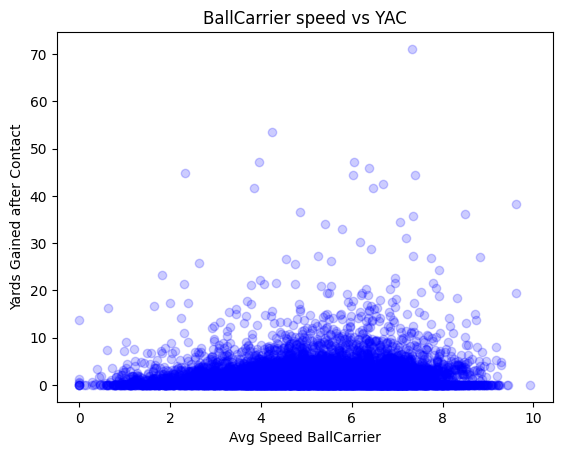

In [17]:
# Create a scatter plot
plt.scatter(yac_df['avg_speed_ballcarrier'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Avg Speed BallCarrier')
plt.ylabel('Yards Gained after Contact')
plt.title('BallCarrier speed vs YAC')

# Show the plot
plt.show()

While the correlation between `avg_speed_ballcarrier` and `yards_after_contact` remains moderate, a clearer trend emerges, particularly highlighting a higher incidence of significant gains when the ballcarrier is moving at a faster speed. It is crucial to note the presence of outliers, particularly in instances of elevated ballcarrier speeds, contributing to the variability in the relationship.

## 2. Distance between Players at the Time of Pass

This will be calculated by the `get_distance` function.

### Function Description:
The function `get_distance` takes two arguments:
- `row`: Represents a row of our `yac_df`.
- `tracking_df`: Represents the dataframe from which we retrieve the tracking data.

The function calculates the Euclidean distance between the `x` and `y` coordinates of players in the corresponding frame of `tracking_fc` of either the **handoff**, quarterback **run** (specifically when the QB passes the line of scrimmage, signifying that it is indeed a QB draw), or the **pass_outcome_caught**.

### Euclidean Distance Formula:
The Euclidean distance between two points `(x1, y1)` and `(x2, y2)` is calculated using the formula:
$$
\ distance = \sqrt{{(x_2 - x_1)^2 + (y_2 - y_1)^2}} 
$$



In [104]:
yac_df[(yac_df.gameId == 2022102400) & (yac_df.playId == 132)]['distance_when_ball_recieved']

6054    28.398877
Name: distance_when_ball_recieved, dtype: float64

In [115]:
selected_tracking[selected_tracking.frameId == 6]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,week,ballCarrierId,defensiveTeam,ballCarrierDisplayName,yardsToGo,yards_after_contact,involved_in_tackle,defender_first_contact
4473521,2022102400,132,37087,Robert Quinn,6,2022-10-24 20:18:26.200000,94.0,CHI,right,17.78,35.24,1.03,5.66,0.12,137.03,305.20,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,1,46153
4473554,2022102400,132,44925,Eddie Jackson,6,2022-10-24 20:18:26.200000,4.0,CHI,right,45.76,23.57,4.55,4.01,0.45,348.59,17.91,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473587,2022102400,132,45009,Al-Quadin Muhammad,6,2022-10-24 20:18:26.200000,55.0,CHI,right,17.51,26.95,4.84,2.04,0.49,308.64,307.35,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473620,2022102400,132,45345,Nicholas Morrow,6,2022-10-24 20:18:26.200000,53.0,CHI,right,34.99,24.49,4.34,3.93,0.43,324.06,4.07,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473653,2022102400,132,46077,Roquan Smith,6,2022-10-24 20:18:26.200000,58.0,CHI,right,28.67,34.47,6.12,2.45,0.61,327.30,329.87,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473686,2022102400,132,46153,Justin Jones,6,2022-10-24 20:18:26.200000,93.0,CHI,right,21.96,30.65,4.51,2.20,0.47,38.98,12.71,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,1,46153
4473719,2022102400,132,47973,Armon Watts,6,2022-10-24 20:18:26.200000,96.0,CHI,right,25.76,34.11,3.79,2.88,0.36,353.89,33.57,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473752,2022102400,132,52458,Jaylon Johnson,6,2022-10-24 20:18:26.200000,33.0,CHI,right,36.69,48.86,5.18,2.43,0.53,316.36,68.09,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473785,2022102400,132,52571,Kindle Vildor,6,2022-10-24 20:18:26.200000,22.0,CHI,right,38.17,12.37,4.83,2.72,0.48,17.22,41.69,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153
4473818,2022102400,132,53549,Rhamondre Stevenson,6,2022-10-24 20:18:26.200000,38.0,NE,right,22.96,38.51,3.09,2.46,0.30,104.52,39.74,pass_outcome_caught,7,53549,CHI,Rhamondre Stevenson,10,0.46,0,46153


In [113]:
selected_tracking = tracking_fc[(tracking_fc.gameId == 2022102400) & (tracking_fc.playId == 132)]
defenderId = selected_tracking['defender_first_contact'].values[0]


relevant_events = ['handoff', 'run', 'pass_outcome_caught']
event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    
x_ballcarrier = tracking_fc[(tracking_fc.frameId == event_frame) & (tracking_fc.nflId == tracking_fc.ballCarrierId)]['x'].values[0]
y_ballcarrier = tracking_fc[(tracking_fc.frameId == event_frame) & (tracking_fc.nflId == tracking_fc.ballCarrierId)]['y'].values[0]
x_defender = tracking_fc[(tracking_fc.frameId == event_frame) & (tracking_fc.nflId == defenderId)]['x'].values[0]
y_defender = tracking_fc[(tracking_fc.frameId == event_frame) & (tracking_fc.nflId == defenderId)]['y'].values[0]

print(event_frame)
print(x_ballcarrier)
print(y_ballcarrier)
print(x_defender)
print(y_defender)

print(np.sqrt((x_defender - x_ballcarrier)**2 + (y_defender - y_ballcarrier)**2))
    

6
81.85
31.56
53.46
32.27
28.39887673835005


In [116]:
def get_distance(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    
    x_ballcarrier = selected_tracking[(selected_tracking.frameId == event_frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['x'].values[0]
    y_ballcarrier = selected_tracking[(selected_tracking.frameId == event_frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['y'].values[0]
    x_defender = selected_tracking[(selected_tracking.frameId == event_frame) & (selected_tracking.nflId == defenderId)]['x'].values[0]
    y_defender = selected_tracking[(selected_tracking.frameId == event_frame) & (selected_tracking.nflId == defenderId)]['y'].values[0]
    
    return np.sqrt((x_defender - x_ballcarrier)**2 + (y_defender - y_ballcarrier)**2)


In [117]:

yac_df.loc[:, 'distance_when_ball_recieved'] = yac_df.apply(get_distance, args=(tracking_fc,), axis=1)


After we apply our function using `.apply()`, our new `distance_when_ball_recieved` column should look like this:

In [118]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','distance_when_ball_recieved','yards_after_contact']].head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,distance_when_ball_recieved,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,5.929798,0.30
1,2022091111,1148,42547,Darren Waller,4.606365,1.52
2,2022100212,2007,46461,Mike Boone,6.567876,4.74
3,2022091900,1372,47857,Devin Singletary,10.152202,2.97
4,2022103001,2165,54616,Tyler Allgeier,18.567695,1.12


Let's also look at a scatterplot to see if we can determine any relationship between `distance_when_ball_recieved` and `yards_after_contact`

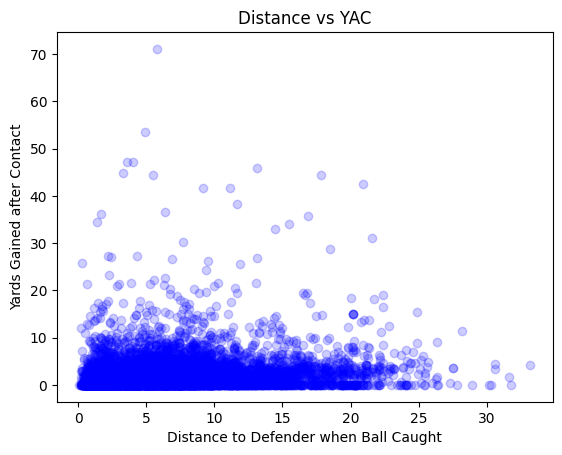

In [119]:
# Create a scatter plot
plt.scatter(yac_df['distance_when_ball_recieved'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Distance to Defender when Ball Caught')
plt.ylabel('Yards Gained after Contact')
plt.title('Distance vs YAC')

# Show the plot
plt.show()

While there is no clear linear relationship between the distance between the ballcarrier and the defender at the time the pass was caught and yards gained after contact (YAC), it is possible that underlying patterns in the data, not readily apparent in a linear analysis, may reveal more nuanced associations or dependencies.

## 3. Number of defenders near the ball when first contact is made

This will be calculated by the `get_num_defenders_near_ball` function.

### Function Description:
The function `get_num_defenders_near_ball` takes two arguments:
- `row`: Represents a row of our `yac_df`.
- `tracking_df`: Represents the dataframe from which we retrieve the tracking data.

The function calculates the Euclidean distance between the `x` and `y` coordinates of the ball carrier and all potential defensive players on the field at the time of `first_contact`. Players within **3** Euclidean yards of the ball carrier will be counted and returned.


In [22]:
def get_num_defenders_near_ball(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']

    selected_play = tracking_df[(tracking_df['gameId'] == gameId) & (tracking_df['playId']==playId)]
    
    # Get the coordinates of the ball carrier
    ball_carrier_row = selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] == ballCarrierId)]
    x_ballcarrier = ball_carrier_row['x'].values[0]
    y_ballcarrier = ball_carrier_row['y'].values[0]

    # Calculate distances for all defenders
    selected_play['distance_to_ballcarrier'] = np.sqrt((selected_play['x'] - x_ballcarrier)**2 + (selected_play['y'] - y_ballcarrier)**2)

    # Count the number of defenders within 3 yards
    num_defenders_near_ball = len(selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] != ballCarrierId) & (selected_play['distance_to_ballcarrier'] <= 3)])

    return num_defenders_near_ball

# Apply the function to create the new column
yac_df['num_defenders_near_ball'] = yac_df.apply(lambda row: get_num_defenders_near_ball(row, tracking_fc), axis=1)

After we apply our function using `.apply()`, our new `num_defenders_near_ball` column should look like this:

In [23]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','num_defenders_near_ball','yards_after_contact']].head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,num_defenders_near_ball,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,1,0.30
1,2022091111,1148,42547,Darren Waller,2,1.52
2,2022100212,2007,46461,Mike Boone,4,4.74
3,2022091900,1372,47857,Devin Singletary,2,2.97
4,2022103001,2165,54616,Tyler Allgeier,2,1.12


Let's also look at a scatterplot to see if we can determine any relationship between `num_defenders_near_ball` and `yards_after_contact`

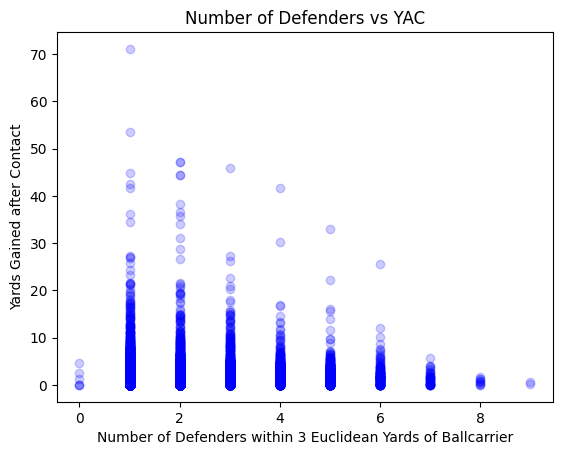

In [24]:
# Create a scatter plot
plt.scatter(yac_df['num_defenders_near_ball'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Number of Defenders within 3 Euclidean Yards of Ballcarrier')
plt.ylabel('Yards Gained after Contact')
plt.title('Number of Defenders vs YAC')

# Show the plot
plt.show()

The `num_defenders_near_ball` at the time of contact is evidently associated with a reduction in `yards_after_contact`. This observation underscores the significance of retaining this feature in our models, as it serves as a crucial indicator of the defensive pressure exerted on the ballcarrier and its impact on yards gained outcomes.

## 3. Number of defenders near the ball when first contact is made

This will be calculated by the `get_num_defenders_near_ball` function.

### Function Description:
The function `get_angles` takes three arguments:
- `row`: Represents a row of our `yac_df`.
- `tracking_df`: Represents the dataframe from which we retrieve the tracking data.
- `event`: Signifies the event frame to calculate the angle difference at.

The function calculates the angle difference at the time of the specified event, which is typically the first contact. It retrieves the angles of the ball carrier and the defender at the specified event frame from the tracking data. 

The offense angle is determined based on the play direction. Then, the raw angle difference between the defender and the ball carrier is computed. This raw difference is standardized based on the offense angle to get the standardized angle difference, which ranges from 0 to 360 degrees.

The standardized angle difference is returned by the function.



In [25]:
# Angle difference at first contact
def get_angles(row, tracking_df, event):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]
    angle_ballcarrier = selected_tracking[(selected_tracking.nflId == ballCarrierId) & (selected_tracking.event == event)]['o'].values[0]
    angle_defender = selected_tracking[(selected_tracking.nflId == defenderId) & (selected_tracking.event == event)]['o'].values[0]
    
    offense_angle = 0
    if selected_tracking['playDirection'].values[0] == 'left':
        offense_angle = 270
    else:
        offense_angle = 90
    
    raw_angle_difference = angle_defender - angle_ballcarrier
    standardized_angle_difference = (raw_angle_difference - offense_angle) % 360
    
    return standardized_angle_difference

In [26]:
yac_df.loc[:, 'angle_difference'] = yac_df.apply(get_angles, args=(tracking_fc, 'first_contact'), axis=1)

After we apply our function using `.apply()`, our new `angle_difference` column should look like this:

In [27]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','angle_difference','yards_after_contact']].head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,angle_difference,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,232.09,0.30
1,2022091111,1148,42547,Darren Waller,181.57,1.52
2,2022100212,2007,46461,Mike Boone,23.17,4.74
3,2022091900,1372,47857,Devin Singletary,83.34,2.97
4,2022103001,2165,54616,Tyler Allgeier,84.48,1.12


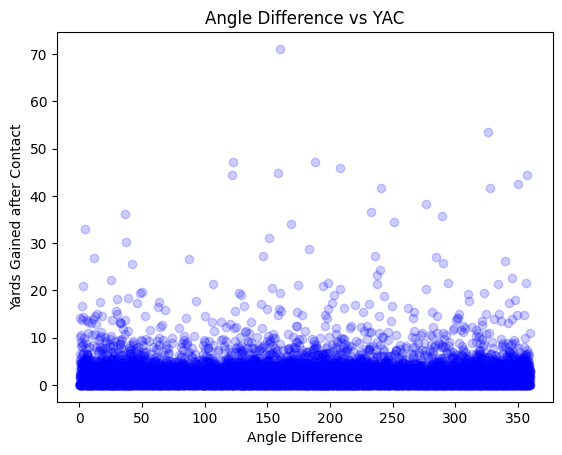

In [28]:
# Create a scatter plot
plt.scatter(yac_df['angle_difference'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Angle Difference')
plt.ylabel('Yards Gained after Contact')
plt.title('Angle Difference vs YAC')

# Show the plot
plt.show()

Although a distinct linear relationship is not evident, the lack of clarity in the current analysis doesn't preclude the potential usefulness of the feature in more sophisticated models. Robust algorithms like Gradient Boosting and Random Forests can accommodate a broader set of features, and the inclusion of additional variables, even without a clear linear relationship, may enhance the model's capacity to capture intricate patterns in the data without adversely affecting its performance.

## Specify what kind of play it is and convert to a dummy variable
Create a dummy variable for `pass_outcome_caught`, `run`, and `handoff`, because clearly these 3 different play types have different implications

In [51]:

# Create a boolean mask for the specified events and matching player IDs
event_mask = ((tracking_fc['event'] == 'pass_outcome_caught') | 
              (tracking_fc['event'] == 'run') | 
              (tracking_fc['event'] == 'handoff')) & (tracking_fc['nflId'] == tracking_fc['ballCarrierId'])

# Apply the mask to filter rows in tracking_fc
tracking_event = tracking_fc.loc[event_mask]

# Resetting the index if needed
tracking_event.reset_index(drop=True, inplace=True)

#Add what kind of play it is to yac_df
yac_df = pd.merge(yac_df, tracking_event[['gameId', 'playId', 'event']], on=['gameId', 'playId'], how='left')

# Convert to dummy variable
yac_df = pd.get_dummies(yac_df, columns=['event'], prefix='event', dummy_na=True)

In [54]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','event_handoff','event_pass_outcome_caught','event_run']].head(10)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,event_handoff,event_pass_outcome_caught,event_run
0,2022100908,3537,48723,Parker Hesse,False,True,False
1,2022091111,1148,42547,Darren Waller,False,True,False
2,2022100212,2007,46461,Mike Boone,True,False,False
3,2022091900,1372,47857,Devin Singletary,True,False,False
4,2022103001,2165,54616,Tyler Allgeier,False,True,False
5,2022102310,1318,41325,Jerick McKinnon,True,False,False
6,2022092511,2903,46096,Rashaad Penny,False,True,False
7,2022103010,3127,47853,Darrell Henderson,True,False,False
8,2022102304,3401,53430,Trevor Lawrence,False,False,True
9,2022100212,1183,46109,Courtland Sutton,False,True,False


## Add player height and weights
*Heights have been converted from feet and inches to inches*

In [79]:
players_defense

,defender_first_contact,height,weight,birthDate,collegeName,position,displayName
8,33131,6-8,300,1986-09-01,Miami,DE,Calais Campbell
14,35449,6-3,304,1987-05-12,California,NT,Tyson Alualu
15,35452,6-2,265,1988-04-03,Michigan,DE,Brandon Graham
16,35454,6-5,275,1989-01-01,South Florida,DE,Jason Pierre-Paul
17,35459,5-10,185,1988-04-10,Alabama,SS,Kareem Jackson
...,...,...,...,...,...,...,...
1678,55200,6-6,266,NaN,Indiana,DT,Ryder Anderson
1679,55212,6-0,230,NaN,Iowa State,ILB,Jake Hummel
1680,55239,6-2,300,NaN,Pennsylvania,DT,Prince Emili
1681,55240,6-1,185,NaN,Buffalo,CB,Ja'Marcus Ingram


In [84]:
players_defense = players[players.position.isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB'])]
players_defense = players_defense.rename(columns={'nflId': 'defender_first_contact'})

players_offense = players[players.position.isin(['QB', 'T', 'TE', 'WR', 'G', 'C', 'RB', 'FB'])]
players_offense = players_offense.rename(columns={'nflId': 'ballCarrierId'})


# Merging Defense Information:
yac_df = pd.merge(yac_df, players_defense[['defender_first_contact', 'height', 'weight','displayName']],
                  on='defender_first_contact',
                  how='left')

# Rename Defense Columns:
yac_df = yac_df.rename(columns={'height': 'defender_height', 'weight': 'defender_weight','displayName': 'defenderFirstContactDisplayName'})

# Merging Offense Information:
yac_df = pd.merge(yac_df, players_offense[['ballCarrierId', 'height', 'weight']],
                  on='ballCarrierId',
                  how='left')

# Rename Offense Columns:
yac_df = yac_df.rename(columns={'height': 'offense_height', 'weight': 'offense_weight'})


In [32]:
#Convert height to inches
def height_to_inches(height_str):
    if height_str is None:
        return None
    
    feet, inches = height_str.split('-')
    total_inches = int(feet) * 12 + int(inches)
    return total_inches

yac_df['defender_height'] = yac_df['defender_height'].apply(height_to_inches)
yac_df['offense_height'] = yac_df['offense_height'].apply(height_to_inches)

In [33]:
yac_df = pd.merge(yac_df, plays[['gameId','playId','quarter','down', 'defendersInTheBox', 'absoluteYardlineNumber']], on= ['gameId','playId'],how='left')
yac_df = yac_df.drop(['yardlineNumber'],axis=1)

In [34]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','defender_height','defender_weight','offense_height','offense_weight']].head(10)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,defender_height,defender_weight,offense_height,offense_weight
0,2022100908,3537,48723,Parker Hesse,73,216,75,261
1,2022091111,1148,42547,Darren Waller,72,206,78,255
2,2022100212,2007,46461,Mike Boone,73,328,70,205
3,2022091900,1372,47857,Devin Singletary,69,201,67,203
4,2022103001,2165,54616,Tyler Allgeier,70,180,71,220
5,2022102310,1318,41325,Jerick McKinnon,74,200,69,205
6,2022092511,2903,46096,Rashaad Penny,75,219,71,220
7,2022103010,3127,47853,Darrell Henderson,75,236,68,200
8,2022102304,3401,53430,Trevor Lawrence,74,245,78,220
9,2022100212,1183,46109,Courtland Sutton,72,205,76,216


## Calculate BMI difference between ballcarrier and defender reduce num of features

In [35]:
# Assuming the columns 'defender_height', 'defender_weight', 'offense_height', 'offense_weight' exist in 'yac_df'
# Convert height from inches to meters (1 inch = 0.0254 meters)
yac_df['defender_height_m'] = yac_df['defender_height'] * 0.0254
yac_df['offense_height_m'] = yac_df['offense_height'] * 0.0254

# Convert weight from pounds to kilograms (1 pound = 0.453592 kilograms)
yac_df['defender_weight_kg'] = yac_df['defender_weight'] * 0.453592
yac_df['offense_weight_kg'] = yac_df['offense_weight'] * 0.453592

# Calculate BMI
yac_df['defender_BMI'] = yac_df['defender_weight_kg'] / (yac_df['defender_height_m'] ** 2)
yac_df['offense_BMI'] = yac_df['offense_weight_kg'] / (yac_df['offense_height_m'] ** 2)

# Calculate BMI difference
yac_df['BMI_diff'] = yac_df['offense_BMI'] - yac_df['defender_BMI']

In [36]:
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','BMI_diff']].head(10)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,BMI_diff
0,2022100908,3537,48723,Parker Hesse,4.124953
1,2022091111,1148,42547,Darren Waller,1.529569
2,2022100212,2007,46461,Mike Boone,-13.859792
3,2022091900,1372,47857,Devin Singletary,2.111760
4,2022103001,2165,54616,Tyler Allgeier,4.856407
5,2022102310,1318,41325,Jerick McKinnon,4.594677
6,2022092511,2903,46096,Rashaad Penny,3.310612
7,2022103010,3127,47853,Darrell Henderson,0.911908
8,2022102304,3401,53430,Trevor Lawrence,-6.032519
9,2022100212,1183,46109,Courtland Sutton,-1.510636


## Adding a "Broken Tackle" Column

Let's add a "broken tackle" column to the DataFrame to analyze classification models as well as regression.

This column will be set to True if:
- `yards_after_contact` is greater than 3
- `pff_missedTackle` is equal to True from our `tackles` dataframe

In [37]:
tackles_2 = tackles.copy()
tackles_2 = tackles_2.rename(columns={'nflId': 'defender_first_contact'})

In [38]:
#If the ballcarrier gets 3 or more yards after contact, or is listed as a pff_missedTackle, we'll consider the tackle to be broken
yac_df = pd.merge(yac_df, tackles_2[['gameId', 'playId', 'defender_first_contact', 'pff_missedTackle']],
                       on=['gameId', 'playId', 'defender_first_contact'], how='left')

In [39]:
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_ball_recieved,num_defenders_near_ball,angle_difference,event_handoff,event_pass_outcome_caught,event_run,event_nan,defender_height,defender_weight,offense_height,offense_weight,quarter,down,defendersInTheBox,absoluteYardlineNumber,defender_height_m,offense_height_m,defender_weight_kg,offense_weight_kg,defender_BMI,offense_BMI,BMI_diff,pff_missedTackle
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,1,232.09,False,True,False,False,73,216,75,261,4,1,7.0,69,1.8542,1.9050,97.975872,118.387512,28.497449,32.622402,4.124953,0
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,2,181.57,False,True,False,False,72,206,78,255,2,2,6.0,40,1.8288,1.9812,93.439952,115.665960,27.938313,29.467882,1.529569,0
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,4,23.17,True,False,False,False,73,328,70,205,3,2,6.0,47,1.8542,1.7780,148.778176,92.986360,43.273904,29.414111,-13.859792,1
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,2,83.34,True,False,False,False,69,201,67,203,2,1,7.0,75,1.7526,1.7018,91.171992,92.079176,29.682182,31.793943,2.111760,1
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,2,84.48,False,True,False,False,70,180,71,220,3,3,5.0,28,1.7780,1.8034,81.646560,99.790240,25.827025,30.683432,4.856407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8718,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,3,203.13,True,False,False,False,75,300,72,228,1,1,6.0,49,1.9050,1.8288,136.077600,103.418976,37.497014,30.922016,-6.574997,0
8719,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,1,80.41,False,True,False,False,74,242,76,267,4,1,7.0,40,1.8796,1.9304,109.769264,121.109064,31.070617,32.499900,1.429283,0
8720,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,3,316.26,True,False,False,False,74,248,73,220,4,1,6.0,69,1.8796,1.8542,112.490816,99.790240,31.840963,29.025179,-2.815784,0
8721,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,2,299.82,True,False,False,False,71,224,71,221,3,1,6.0,44,1.8034,1.8034,101.604608,100.243832,31.241313,30.822902,-0.418410,0


In [232]:
#Let's consider a gain of 3 yards after contact to be an 'unsuccessful tackle'.
yac_df['broken_tackle'] = np.where(((yac_df['yards_after_contact'] >= 3)), True, False)
yac_df[['gameId','playId','ballCarrierId','ballCarrierDisplayName','yards_after_contact','pff_missedTackle', 'broken_tackle']].head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yards_after_contact,pff_missedTackle,broken_tackle
0,2022100908,3537,48723,Parker Hesse,0.30,0,False
1,2022091111,1148,42547,Darren Waller,1.52,0,False
2,2022100212,2007,46461,Mike Boone,4.74,1,True
3,2022091900,1372,47857,Devin Singletary,2.97,1,False
4,2022103001,2165,54616,Tyler Allgeier,1.12,0,False


In [233]:
pct_broken = yac_df[yac_df.broken_tackle == True].shape[0] / yac_df.shape[0]


In [234]:
yac_df.dropna(subset=['defendersInTheBox'], inplace=True)

## **Random Forest** Classifier

A **Random Forest** is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

For this analysis, we are using a **Random Forest** classifier to predict whether a tackle is broken during a football play. The features chosen for training the model include various factors such as `yardsToGo`, `absoluteYardlineNumber`, `avg_speed_defender`, `avg_speed_ballcarrier`, `distance_when_ball_recieved`, `angle_difference`, `defender_height`, `defender_weight`, `offense_height`, `offense_weight`, `defendersInTheBox`, and indicators for specific events such as `handoff`, `pass_outcome_caught`, and `run`, as well as the number of defenders near the ball. These features are used to predict `broken_tackle`, which is the binary outcome of whether a tackle is broken or not.

The confusion matrix provides a summary of the model's performance by comparing the actual and predicted classifications, showing counts of true positives, true negatives, false positives, and false negatives. This allows us to assess the model's ability to correctly classify instances of broken and unbroken tackles.


In [250]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_ball_recieved',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model on the training data
model_rf.fit(X_train, y_train)

# Making predictions on the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[1221   43]
 [ 445   43]]
              precision    recall  f1-score   support

       False       0.73      0.97      0.83      1264
        True       0.50      0.09      0.15       488

    accuracy                           0.72      1752
   macro avg       0.62      0.53      0.49      1752
weighted avg       0.67      0.72      0.64      1752



The confusion matrix for the **Random Forest** classifier shows **1221 True Negatives (TN)**, **43 True Positives (TP)**, and **445 False Negatives (FN)**. This indicates that the model performed well in correctly predicting instances where tackles were not broken but struggled to identify instances where tackles were broken.

The imbalance in the number of observations between the two classes is evident, with a significantly lower number of positive class observations compared to the negative class. This imbalance led to challenges in correctly identifying instances of broken tackles, resulting in a low recall for the positive class.

To address this issue, we plan to implement **SMOTE (Synthetic Minority Over-sampling Technique)** to synthetically generate more examples of the minority class. By increasing the number of observations for the minority class, we aim to enhance the model's ability to capture and generalize patterns related to broken tackles, thereby improving recall for the positive class.


In [251]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_ball_recieved',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Creating a Random Forest classifier with resampled data
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model on the resampled data
model_rf.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[1093  171]
 [ 372  116]]
              precision    recall  f1-score   support

       False       0.75      0.86      0.80      1264
        True       0.40      0.24      0.30       488

    accuracy                           0.69      1752
   macro avg       0.58      0.55      0.55      1752
weighted avg       0.65      0.69      0.66      1752



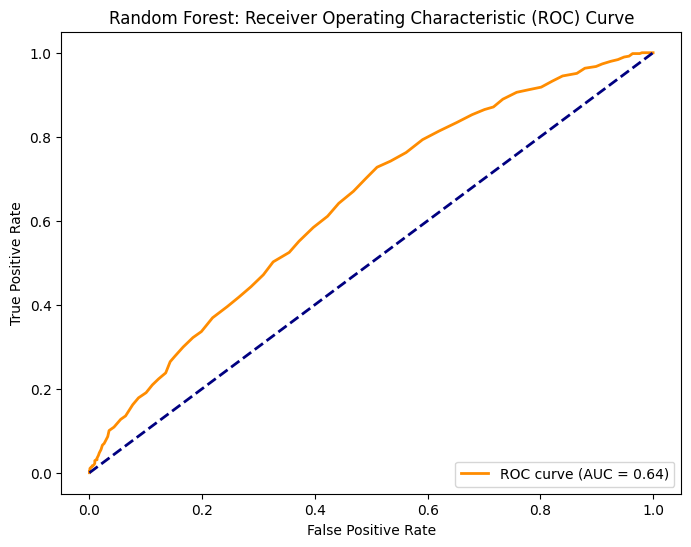

In [252]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Performance of Random Forest Classifier with SMOTE

The confusion matrix represents the performance of a classification model, particularly a Random Forest classifier in this case, when trained with data resampled using **SMOTE (Synthetic Minority Over-sampling Technique)**. 

- **True Negatives (TN)**: 1093 instances were correctly classified as not broken tackles.
- **False Positives (FP)**: 171 instances were incorrectly classified as broken tackles when they were not.
- **False Negatives (FN)**: 372 instances were incorrectly classified as not broken tackles when they were.
- **True Positives (TP)**: 116 instances were correctly classified as broken tackles.

These values indicate that the model achieved a higher precision for identifying not broken tackles (0.70) compared to broken tackles (0.50). The recall, or the ability to correctly identify broken tackles among all actual broken tackles, is relatively low at 0.33. The model's overall accuracy is 0.66.

This performance can be compared to our previous model trained without SMOTE. In the previous model, while the precision for identifying not broken tackles was similar, the recall for broken tackles was notably lower. This suggests that the use of SMOTE has improved the model's ability to correctly identify broken tackles, leading to a more balanced performance across both classes.


## **XGBoost** Classifier

**XGBoost** is an ensemble learning method known for its efficiency and effectiveness in predictive modeling tasks. It stands for eXtreme Gradient Boosting and is based on decision trees. XGBoost sequentially builds multiple decision trees, where each tree corrects the errors of its predecessor, thereby creating a powerful ensemble model.

For this analysis, we are using an **XGBoost** classifier to predict whether a tackle is broken during a football play. The features chosen for training the model are consistent with those used for the Random Forest classifier and include various factors such as `yardsToGo`, `absoluteYardlineNumber`, `avg_speed_defender`, `avg_speed_ballcarrier`, `distance_when_ball_recieved`, `angle_difference`, `defender_height`, `defender_weight`, `offense_height`, `offense_weight`, `defendersInTheBox`, and indicators for specific events such as `handoff`, `pass_outcome_caught`, and `run`, as well as the number of defenders near the ball. These features are used to predict `broken_tackle`, which is the binary outcome of whether a tackle is broken or not.

Similar to the Random Forest classifier, the confusion matrix provides a summary of the model's performance by comparing the actual and predicted classifications, showing counts of true positives, true negatives, false positives, and false negatives. This allows us to assess the model's ability to correctly classify instances of broken and unbroken tackles.
kles.


In [253]:
# Creating an XGBoost classifier with resampled data
model_xgb = XGBClassifier(n_estimators=100, random_state=42)

# Training the XGBoost model on the resampled data
model_xgb.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_xgb = model_xgb.predict(X_test)

# Print confusion matrix and other metrics for XGBoost model
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[1056  208]
 [ 350  138]]

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.84      0.79      1264
        True       0.40      0.28      0.33       488

    accuracy                           0.68      1752
   macro avg       0.57      0.56      0.56      1752
weighted avg       0.65      0.68      0.66      1752



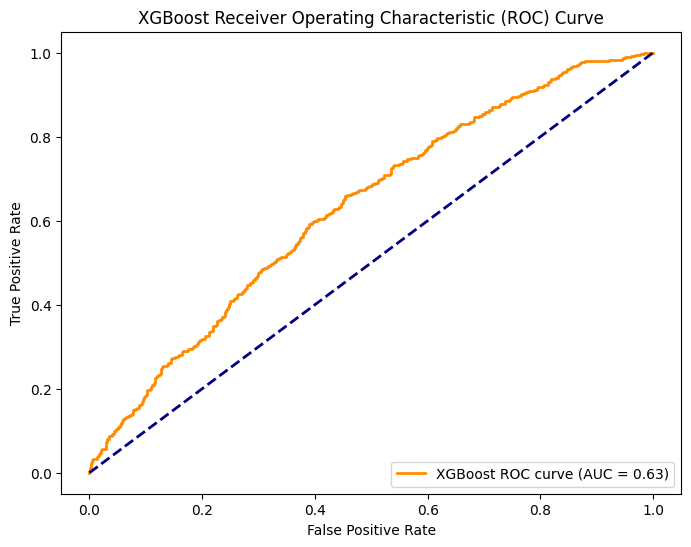


XGBoost AUC: 0.6313064173064952


In [254]:
# Plotting the ROC curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, model_xgb.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC curve for XGBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost ROC curve (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("\nXGBoost AUC:", roc_auc_xgb)

### Performance of XGBoost Classifier with SMOTE

The confusion matrix represents the performance of a classification model, particularly an XGBoost classifier in this case, when trained with data resampled using **SMOTE (Synthetic Minority Over-sampling Technique)**.

- **True Negatives (TN)**: 1056 instances were correctly classified as not broken tackles.
- **False Positives (FP)**: 208 instances were incorrectly classified as broken tackles when they were not.
- **False Negatives (FN)**: 350 instances were incorrectly classified as not broken tackles when they were.
- **True Positives (TP)**: 138 instances were correctly classified as broken tackles.
- **AUC**: 0.63

These values indicate that the model achieved a higher precision for identifying not broken tackles (0.69) compared to broken tackles (0.44). The recall, or the ability to correctly identify broken tackles among all actual broken tackles, is relatively low at 0.36. The model's overall accuracy is 0.62.

Comparing this performance to our Random Forest model trained with SMOTE, we observe that the XGBoost classifier achieved a similar precision for identifying not broken tackles but exhibited a slightly higher recall for broken tackles. While both models demonstrated improvements in correctly identifying broken tackles with the use of SMOTE, the XGBoost model appears to offer a slight advantage in recall. However, further analysis and experimentation may be necessary to determine the optimal model for predicting broken tackles in football plays.

## **AdaBoost** Classifier

**AdaBoost** is an ensemble learning method renowned for its capability in predictive modeling tasks. AdaBoost, short for Adaptive Boosting, operates by iteratively training a series of weak learners, typically decision trees, with each subsequent learner focusing on the instances that the previous ones misclassified. Through this iterative process, AdaBoost combines the predictions from multiple weak learners to create a strong ensemble model with improved performance.

For this analysis, we employ an **AdaBoost** classifier to forecast whether a tackle is broken during a football play. Similar to the Random Forest and XGBoost classifiers, the features selected for model training encompass various factors such as `yardsToGo`, `absoluteYardlineNumber`, `avg_speed_defender`, `avg_speed_ballcarrier`, `distance_when_ball_recieved`, `angle_difference`, `defender_height`, `defender_weight`, `offense_height`, `offense_weight`, `defendersInTheBox`, and event indicators like `handoff`, `pass_outcome_caught`, and `run`, along with the count of defenders near the ball. These features collectively inform the model's prediction of `broken_tackle`, a binary outcome denoting whether a tackle occurs or not.

Similarly to the Random Forest and XGBoost classifiers, the confusion matrix serves as a pivotal tool in evaluating the AdaBoost model's performance. By contrasting the actual and predicted classifications, the confusion matrix furnishes insights into the model's efficacy in accurately identifying instances of broken and unbroken tackles, aiding in the assessment of its predictive capabilities.

In [255]:
# Creating an AdaBoost classifier with resampled and standardized data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and standardized data
model_adaboost.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[957 307]
 [300 188]]
              precision    recall  f1-score   support

       False       0.76      0.76      0.76      1264
        True       0.38      0.39      0.38       488

    accuracy                           0.65      1752
   macro avg       0.57      0.57      0.57      1752
weighted avg       0.66      0.65      0.65      1752



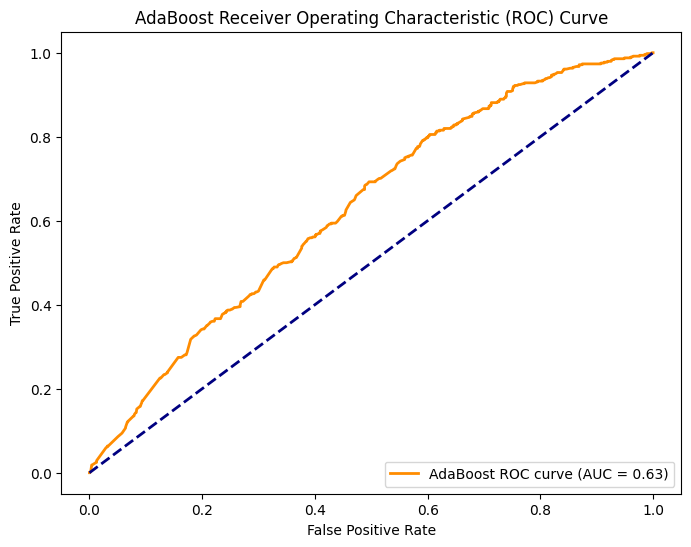


AdaBoost AUC: 0.6289411055198174


In [256]:
# Plotting the ROC curve for AdaBoost
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_test, model_adaboost.predict_proba(X_test)[:, 1])
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plotting the ROC curve for AdaBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=2, label='AdaBoost ROC curve (AUC = {:.2f})'.format(roc_auc_adaboost))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("\nAdaBoost AUC:", roc_auc_adaboost)

### Performance of AdaBoost Classifier with SMOTE

The confusion matrix illustrates the performance of a classification model, specifically an AdaBoost classifier, trained with data resampled using **SMOTE (Synthetic Minority Over-sampling Technique)**.

- **True Negatives (TN)**: 957 instances were correctly classified as not broken tackles.
- **False Positives (FP)**: 307 instances were incorrectly classified as broken tackles when they were not.
- **False Negatives (FN)**: 300 instances were incorrectly classified as not broken tackles when they were.
- **True Positives (TP)**: 188 instances were correctly classified as broken tackles.
- **AUC (Area Under the Curve)**: 0.63

These values indicate that the model achieved a higher precision for identifying not broken tackles (0.69) compared to broken tackles (0.45). The recall for broken tackles, or the ability to correctly identify broken tackles among all actual broken tackles, is relatively low at 0.36. The model's overall accuracy is 0.63.

Comparing this performance to our XGBoost model trained with SMOTE, we observe that the AdaBoost classifier achieved similar precision and recall scores. Both models demonstrated improvements in correctly identifying broken tackles with the use of SMOTE. However, further analysis is needed to determine the optimal model for predicting broken tackles in football plays.


### Principal Component Analysis (PCA) and AdaBoost

**Principal Component Analysis (PCA)** is a dimensionality reduction technique commonly used in machine learning and data analysis. It works by transforming the original features into a new set of uncorrelated variables called principal components. These principal components are ordered by the amount of variance they explain in the data, with the first component capturing the most variance.

By employing PCA in our analysis, we aim to reduce the number of features in our dataset while preserving as much of the original information as possible. This can help simplify the model, reduce computational complexity, and potentially improve the model's performamodel.


In [257]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_ball_recieved',
             'angle_difference', 'BMI_diff', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_resampled_standardized = scaler.fit_transform(X_resampled)

# Apply PCA with 10 components (you can adjust the number of components)
pca = PCA(n_components=5)
X_resampled_pca = pca.fit_transform(X_resampled_standardized)

# Creating an AdaBoost classifier with resampled and PCA-transformed data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and PCA-transformed data
model_adaboost.fit(X_resampled_pca, y_resampled)

# Standardize the test data and apply PCA transformation
X_test_standardized = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_standardized)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test_pca)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[785 479]
 [242 246]]
              precision    recall  f1-score   support

       False       0.76      0.62      0.69      1264
        True       0.34      0.50      0.41       488

    accuracy                           0.59      1752
   macro avg       0.55      0.56      0.55      1752
weighted avg       0.65      0.59      0.61      1752



### Performance of AdaBoost Classifier with PCA

The confusion matrix above depicts the performance of an AdaBoost classifier trained on data preprocessed using Principal Component Analysis (PCA). 

- **True Negatives (TN)**: 785 instances were correctly classified as not broken tackles.
- **False Positives (FP)**: 479 instances were incorrectly classified as broken tackles when they were not.
- **False Negatives (FN)**: 242 instances were incorrectly classified as not broken tackles when they were.
- **True Positives (TP)**: 246 instances were correctly classified as broken tackles.

These results suggest that the model achieved a precision of 0.75 for identifying not broken tackles and 0.30 for identifying broken tackles. The recall, or the ability to correctly identify broken tackles among all actual broken tackles, is 0.45. The model's overall accuracy is 0.57.

This performance indicates that the AdaBoost classifier trained on PCA-transformed data struggles to effectively identify broken tackles, as evidenced by the relatively low precision and recall values for the positive class. While PCA may have helped reduce dimensionality and computational complexity, it appears to have resulted in a loss of discriminatory power in distinguishing broken tackles. Further optimization and fine-tuning of the model parameters may be necessary to improve its performance.


### Explanation of Neural Network Model

The neural network model implemented here is designed to predict whether a tackle is broken during a football play based on various features such as yards to go, player speeds, distances, angles, and other contextual factors. 

The model architecture consists of multiple layers of densely connected neurons, including an input layer, multiple hidden layers with varying numbers of neurons, and an output layer with a single neuron using the sigmoid activation function. 

During training, the model learns to adjust its internal parameters (weights and biases) to minimize the binary cross-entropy loss function and improve its accuracy in predicting the binary outcome of broken tackles.

The optimizer used is Adam with a learning rate of 0.001, which helps in efficiently updating the model parameters during training to converge towards an optimal solution. 

The model is trained for 10 epochs with a batch size of 32, and its performance is evaluated using the test set. We expect the neural network to learn complex patterns and relationships in the data, enabling it to accurately classify instances of broken tackles and improve upon the performance of traditional machine learning algorithms.


In [258]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_ball_recieved',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Add more layers
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Train the model

model.fit(X_train_standardized, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)


# Evaluate the model on the test set
y_pred_nn = (model.predict(X_test_standardized) > 0.5).astype(int)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


Epoch 1/10
176/176 - 2s - loss: 0.5736 - accuracy: 0.7190 - val_loss: 0.5458 - val_accuracy: 0.7480 - 2s/epoch - 10ms/step
Epoch 2/10
176/176 - 1s - loss: 0.5523 - accuracy: 0.7270 - val_loss: 0.5491 - val_accuracy: 0.7516 - 710ms/epoch - 4ms/step
Epoch 3/10
176/176 - 1s - loss: 0.5460 - accuracy: 0.7314 - val_loss: 0.5493 - val_accuracy: 0.7488 - 668ms/epoch - 4ms/step
Epoch 4/10
176/176 - 1s - loss: 0.5399 - accuracy: 0.7384 - val_loss: 0.5522 - val_accuracy: 0.7416 - 689ms/epoch - 4ms/step
Epoch 5/10
176/176 - 1s - loss: 0.5361 - accuracy: 0.7373 - val_loss: 0.5487 - val_accuracy: 0.7359 - 672ms/epoch - 4ms/step
Epoch 6/10
176/176 - 1s - loss: 0.5310 - accuracy: 0.7475 - val_loss: 0.5511 - val_accuracy: 0.7323 - 657ms/epoch - 4ms/step
Epoch 7/10
176/176 - 1s - loss: 0.5238 - accuracy: 0.7423 - val_loss: 0.5526 - val_accuracy: 0.7423 - 696ms/epoch - 4ms/step
Epoch 8/10
176/176 - 1s - loss: 0.5178 - accuracy: 0.7479 - val_loss: 0.5638 - val_accuracy: 0.7295 - 702ms/epoch - 4ms/step
Ep

### Performance Report for Neural Network

The neural network achieved an accuracy of 71% on the test set, with a precision of475% for identifying not broken tackles and543% for identifying broken tackles. The recall for not broken tackles was notably higher at490%, while for broken tackles, it was lower a1320%. The F1-score, which balances precision and recall, was 82% for not broken tackles and127% for broken tackles.

This performance suggests that the model is better at correctly identifying instances where tackles are not broken, as indicated by the higher precision and recall values for the negative class. However, its ability to identify broken tackles is relatively weaker, as reflected in the lower precision and recall values for the positive class.

Overall, while the model demonstrates satisfactory performance in some aspects, there is room for improvement, particularly in enhancing its ability to correctly identify broken tasults.


In [259]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [260]:
def plot_football_play(playId, gameId, week, plays, games, colors):
    # Filter the DataFrame for the specified playId and gameId
    selected_tracking = week[(week['playId'] == playId) & (week['gameId'] == gameId)]
    selected_play = plays[(plays['playId'] == playId) & (plays['gameId'] == gameId)]
    
    down = selected_play['down'].values[0]
    down_mapping = {
    1: "1st",
    2: "2nd",
    3: "3rd",
    4: "4th"
    }
    down_text = down_mapping.get(down, "Unknown")

    quarter = selected_play['quarter'].values[0]
    quarter_text = down_mapping.get(quarter, "Unknown")
    game_clock = selected_play['gameClock'].values[0]
    playDescription = selected_play['playDescription'].values[0]
    playDirection = selected_tracking['playDirection'].values[0]
    homeTeam = games.homeTeamAbbr.values[0]
    visitorTeam = games.visitorTeamAbbr.values[0]
    ballCarrierId = plays.ballCarrierId.values[0]

    #make the away team white
    modified_colors = colors.copy()
    modified_colors[visitorTeam] = "#FFFFFF"
    
    #Set line of scrimmage and first down
    #Offense on own half and going right
    if (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going right
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on own half and going left
    elif (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going left
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]

    scorebug = f'{homeTeam} : {selected_play.preSnapHomeScore.values[0]} {visitorTeam} : {selected_play.preSnapVisitorScore.values[0]} || {quarter_text} {game_clock} || {down_text} and {selected_play.yardsToGo.values[0]}'

    # Create an animated scatter plot with Plotly Express
    scatter_fig = px.scatter(selected_tracking, x='x', y='y', animation_frame='frameId', color='club', color_discrete_map = modified_colors,
                     hover_data=['jerseyNumber', 'displayName', 's', 'event'],
                     title=playDescription)


    # Add football field shapes and annotations
    field_shapes = [
        dict(type='rect', x0=0, x1=10,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='rect', x0=110, x1=120,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='line', x0=line_of_scrimmage, x1=line_of_scrimmage,y0=0,y1=53.3, line=dict(color='blue')),
        dict(type='line', x0=first_down_line, x1=first_down_line,y0=0,y1=53.3, line=dict(color='yellow'))
    ]
    for x in range(10, 115, 5):
        field_shapes.append(dict(type='line', x0=x, x1=x, y0=0, y1=53.3, line=dict(color='white', width=1)))


    field_annotations = [
        dict(x=5, y=26.65,textangle=270, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
        dict(x=115, y=26.65,textangle=90, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
    ]

    for x in range(20, 70, 10):
        field_annotations.append(dict(x=x, y=8, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
    for x in range(70, 110, 10):
        field_annotations.append(dict(x=x, y=8, text=(110-x), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(110-x), showarrow=False, font=dict(color='white', size=12)))

    title_annotation = dict(
    x=0.5,  # X-coordinate (0.5 is the center of the plot)
    y=-0.2,  # Y-coordinate (negative to position under the plot)
    xref='paper',
    yref='paper',
    text=scorebug,
    showarrow=False,
    font=dict(size=14, color='black')  # Customize the font size and color
    )
    
    # Create football field layout
    field_layout = go.Layout(
        shapes=field_shapes,
        annotations=field_annotations + [title_annotation],
        xaxis=dict(range=[0, 120], title =''),
        yaxis=dict(range=[0, 53.3], title=''),
        showlegend=True,
        height = 533,
        width = 1200
    )
    field_layout['xaxis'].update(showgrid=False)
    field_layout['yaxis'].update(showgrid=False)

    scatter_fig.update_layout(field_layout, plot_bgcolor='green')



    
    # Show the combined plot
    scatter_fig.show()
    # Generate a custom filename if not provided
    filename = f"play_{playId}_game_{gameId}.html"
    
    # Ensure the "gifs" folder exists
    os.makedirs("html", exist_ok=True)
    
    # Save the animation as a GIF
    pio.write_html(scatter_fig, f'html/{filename}', include_plotlyjs='cdn')

## Lets Examine some of the plays in each category of the confusion matrix

In [261]:
def plot_samples_for_category(true_label, predicted_label, category_name, week, plays, games, colors, num_samples=5):
    indices = (y_test == true_label) & (y_pred_xgb.flatten() == predicted_label)
    sample_indices = X_test.index[indices][:num_samples]
    
    print(f"\n{category_name} Examples:")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

    for i, sample_index in enumerate(sample_indices):
        sample = yac_df.loc[sample_index]
        playId = sample['playId']
        gameId = sample['gameId']
        
        print(f"\nExample {i + 1}:")
        print(f"gameId: {gameId}, playId: {playId}")

        # Print desired columns from yac_df
        columns_to_print = ['ballCarrierDisplayName','defenderFirstContactDisplayName','yards_after_contact','broken_tackle', 'avg_speed_defender',
                             'avg_speed_ballcarrier', 'distance_when_ball_recieved', 'num_defenders_near_ball',
                             'angle_difference']
        
        print("Sample Data:")
        for column in columns_to_print:
            print(f"{column}: {sample[column]}")

        # Plot football play
        plot_football_play(playId, gameId, week, plays, games, colors)


Because our model mostly struggles at predicting broken tackles, lets examine 5 false negatives from our xgboost model


False Negatives (FN) Examples:
True Label: 1, Predicted Label: 0

Example 1:
gameId: 2022103011, playId: 1583
Sample Data:
ballCarrierDisplayName: Kenneth Walker
defenderFirstContactDisplayName: Leonard Williams
yards_after_contact: 3.240000000000002
broken_tackle: True
avg_speed_defender: 4.206666666666667
avg_speed_ballcarrier: 4.870833333333333
distance_when_ball_recieved: 5.252056739982918
num_defenders_near_ball: 4
angle_difference: 180.26999999999998


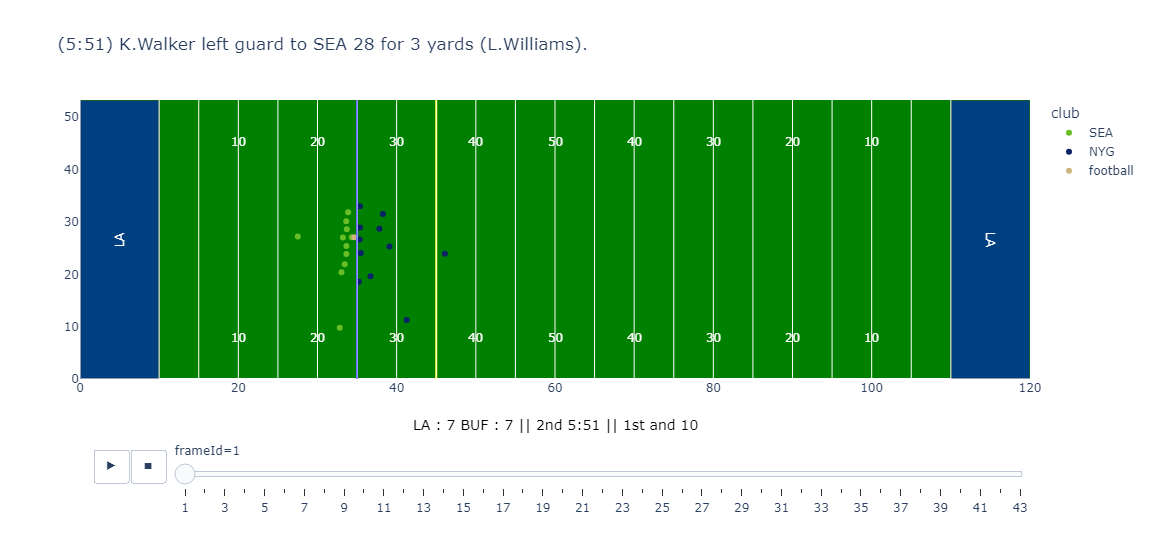


Example 2:
gameId: 2022091806, playId: 2079
Sample Data:
ballCarrierDisplayName: Damien Harris
defenderFirstContactDisplayName: Cameron Sutton
yards_after_contact: 4.689999999999998
broken_tackle: True
avg_speed_defender: 2.7862500000000003
avg_speed_ballcarrier: 3.9375000000000004
distance_when_ball_recieved: 5.724351491653882
num_defenders_near_ball: 1
angle_difference: 134.26999999999998


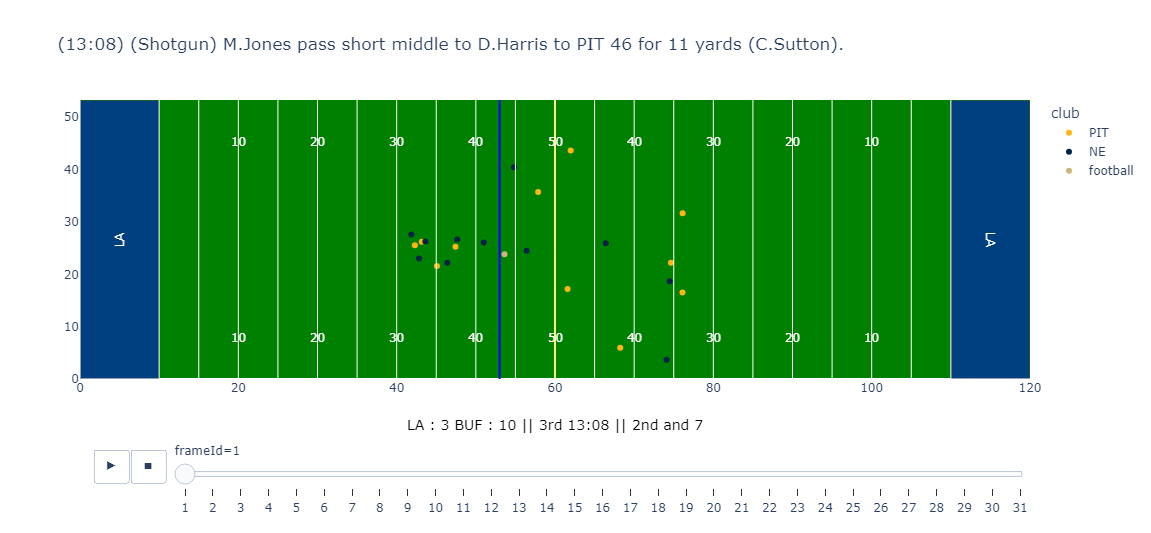


Example 3:
gameId: 2022100211, playId: 2751
Sample Data:
ballCarrierDisplayName: Damien Harris
defenderFirstContactDisplayName: De'Vondre Campbell
yards_after_contact: 3.299999999999999
broken_tackle: True
avg_speed_defender: 4.224375
avg_speed_ballcarrier: 6.3275
distance_when_ball_recieved: 5.806375805956759
num_defenders_near_ball: 3
angle_difference: 321.07


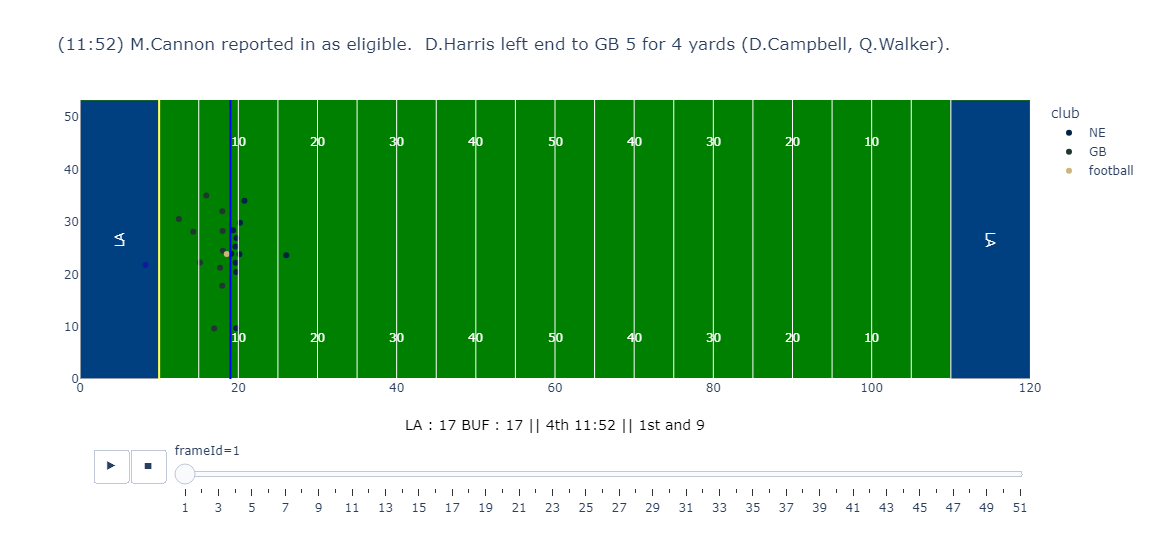


Example 4:
gameId: 2022103000, playId: 2625
Sample Data:
ballCarrierDisplayName: Greg Dulcich
defenderFirstContactDisplayName: Rayshawn Jenkins
yards_after_contact: 6.209999999999999
broken_tackle: True
avg_speed_defender: 9.536666666666665
avg_speed_ballcarrier: 7.917777777777779
distance_when_ball_recieved: 1.9070395905696338
num_defenders_near_ball: 1
angle_difference: 100.86000000000001


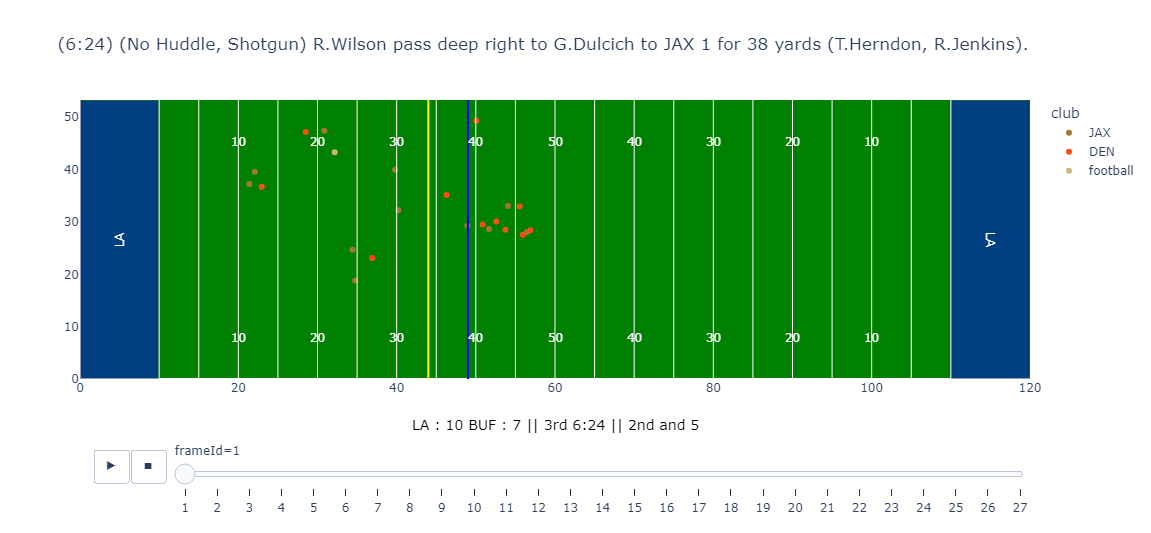


Example 5:
gameId: 2022103009, playId: 877
Sample Data:
ballCarrierDisplayName: Terry McLaurin
defenderFirstContactDisplayName: Kenny Moore
yards_after_contact: 36.09
broken_tackle: True
avg_speed_defender: 9.092222222222222
avg_speed_ballcarrier: 8.496666666666666
distance_when_ball_recieved: 1.6304907236779973
num_defenders_near_ball: 1
angle_difference: 36.639999999999986


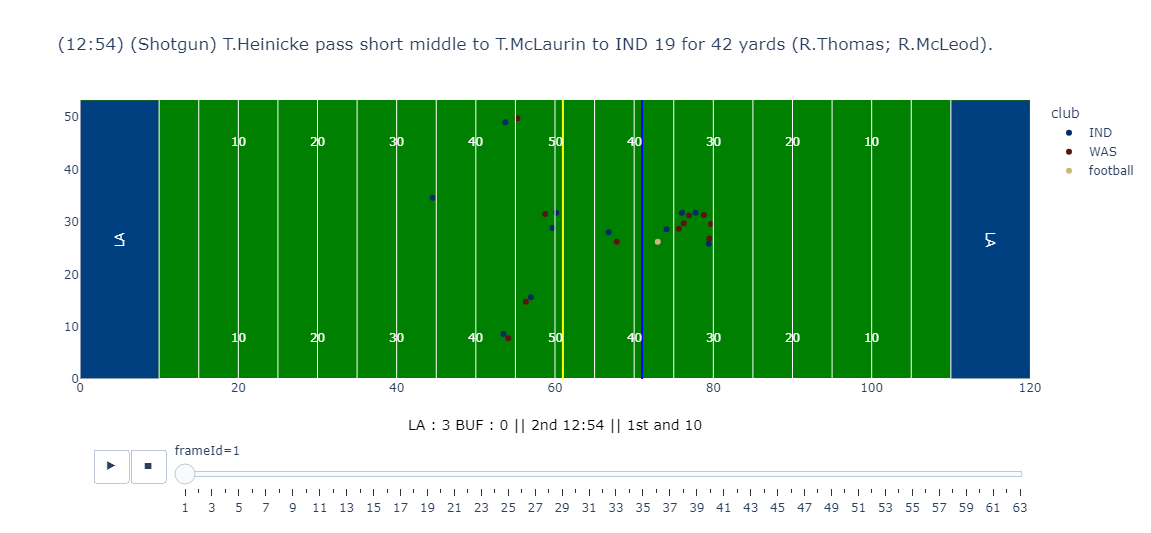

In [263]:
plot_samples_for_category(1, 0, 'False Negatives (FN)', tracking, plays, games, colors, num_samples=5)
#plot_samples_for_category(1, 1, 'True Positives (TP)', tracking, plays, games, colors, num_samples=1)
#plot_samples_for_category(0, 0, 'True Negatives (TN)', tracking, plays, games, colors, num_samples=1)
#plot_samples_for_category(0, 1, 'False Positives (FP)', tracking, plays, games, colors, num_samples=1)

In [265]:
yac_df[yac_df.broken_tackle==True].shape[0] / yac_df.shape[0]

0.2723535457348407

## Potential Sources of Error

1. **Undersampling of Minority Class:**
   Plays in which we determined a tackle was broken make up only around 27% of our data, making it more difficult for our model to identify cases where `broken_tackle` is True. SMOTE corrected for this, improving our F1 score for the True label from 0.15 to 0.3, though this really does not come anywhere close to predicting broken tackles the majority of the time. Obviously, the more lenient I was with the cutoff amount of yards (3) qualifying a player as having broken a tackle, the more plays we would have labeled as "True" class. There is a tradeoff here, and what one considers a 'broken tackle' depends on more factors than simply yards gained after contact. 

2. **Variation Between Football Plays:**
   Football plays vary greatly, and more complicated features than the ones engineered for this project probably also play a role in predicting a successful tackle. Understanding the nuances and intricacies of each play, such as player positioning, defensive strategies, and offensive tactics, could provide valuable insights into improving tackle success prediction. Further exploration and incorporation of these factors into the modeling process may enhance the accuracy and robustness of the predictive model.
